In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import prince # for multiple correspondence analysis
from sklearn.feature_selection import SelectKBest, chi2 # for chi-squared feature selection
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
#!pip install kmodes
from mlxtend.frequent_patterns import apriori, association_rules 
from kmodes.kmodes import KModes
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import matplotlib.font_manager
import matplotlib.ticker as mtick # For specifying the axes tick format 
%matplotlib inline

# importing data

In [2]:
df = pd.read_csv('Rudraksh Mishra, Ambika Chundru, Ashwath Ramesh--dataset.csv')
df.columns = [label.lower() for label in df.columns]
df.drop(labels=['customerid'], axis=1,inplace=True)
dfo=df.copy()
df

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


# Data visualization

### Churn analysis on monthly charges and tenure

C:\Users\rudra\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\rudra\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\rudra\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

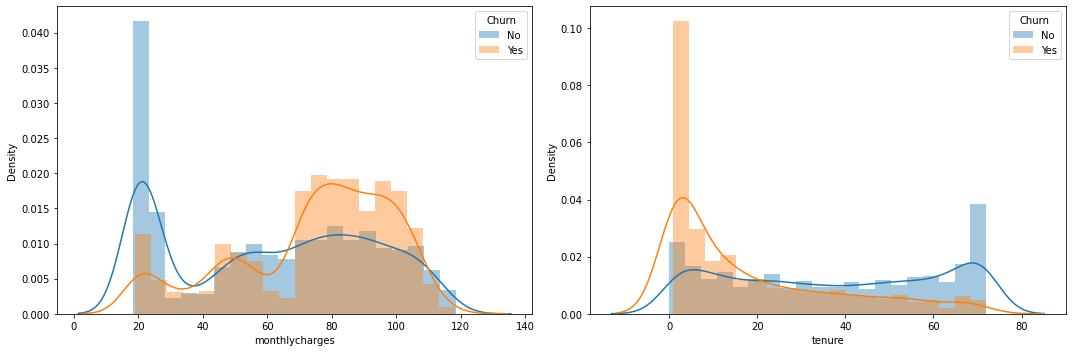

In [3]:
df_grouped = df.groupby(by='churn')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
cols = ['monthlycharges', 'tenure']
for i in range(len(cols)):
    sns.distplot(df_grouped.get_group('No')[cols[i]], bins=20, ax=axes[i], label='No')
    sns.distplot(df_grouped.get_group('Yes')[cols[i]], bins=20, ax=axes[i], label='Yes')
    axes[i].legend(title='Churn')

fig.tight_layout()

### Percent of churns from different tenure periods

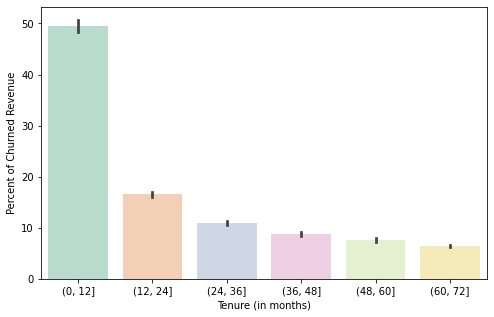

In [4]:
churned_users = df_grouped.get_group('Yes')
bins = [(0, 12), (12, 24), (24, 36), (36, 48), (48, 60), (60, 72)]
binned_tenure = pd.cut(list(churned_users['tenure']),bins=pd.IntervalIndex.from_tuples(bins))
revenue_share = churned_users['monthlycharges'] / churned_users['monthlycharges'].sum()
temp_df = pd.DataFrame(data={'tenure':binned_tenure, 'revenue_share(%)': revenue_share * 100})
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
sns.barplot(x='tenure', y='revenue_share(%)', data=temp_df,estimator=np.sum, palette='Pastel2', ax=ax)
ax.set_xlabel('Tenure (in months)')
ax.set_ylabel('Percent of Churned Revenue');

### Churn count from different contracts

contract,Month-to-month,One year,Two year
churn,,,
No,2220,1307,1647
Yes,1655,166,48


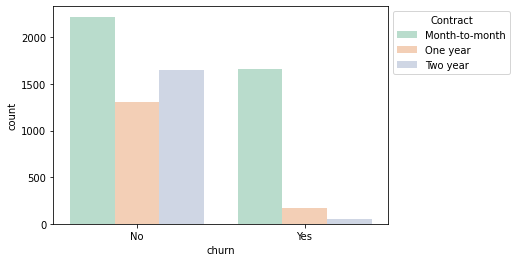

In [5]:
display(pd.crosstab(df['churn'], df['contract'], dropna=False))
sns.countplot(x='churn', hue='contract', data=df, palette='Pastel2')
plt.legend(title='Contract', bbox_to_anchor=(1, 1));

### Percentage of churn by contract types

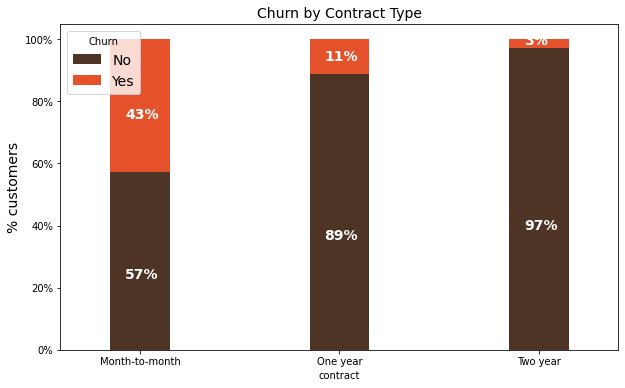

In [6]:
colors = ['#4D3425','#E4512B']
contract_churn = df.groupby(['contract','churn']).size().unstack()
ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar',width = 0.3,stacked = True,rot = 0, figsize = (10,6),color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'Churn')
ax.set_ylabel('% customers',size = 14)
ax.set_title('Churn by Contract Type',size = 14)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),color = 'white',weight = 'bold',size = 14)

# converting to categorical

In [7]:
df['gender'].replace(to_replace=[['Female'],['Male']],value=[0,1],inplace=True)
df['partner'].replace(to_replace=[['No'],['Yes']],value=[0,1],inplace=True)
df['dependents'].replace(to_replace=[['No'],['Yes']],value=[0,1],inplace=True)
df['phoneservice'].replace(to_replace=[['No'],['Yes']],value=[0,1],inplace=True)
df['paperlessbilling'].replace(to_replace=[['No'],['Yes']],value=[0,1],inplace=True)
df['multiplelines'].replace(to_replace=[['No'],['Yes']],value=[0,1],inplace=True)
df['onlinesecurity'].replace(to_replace=[['No'],['Yes']],value=[0,1],inplace=True)
df['onlinebackup'].replace(to_replace=[['No'],['Yes']],value=[0,1],inplace=True)
df['deviceprotection'].replace(to_replace=[['No'],['Yes']],value=[0,1],inplace=True)
df['techsupport'].replace(to_replace=[['No'],['Yes']],value=[0,1],inplace=True)
df['streamingtv'].replace(to_replace=[['No'],['Yes']],value=[0,1],inplace=True)
df['streamingmovies'].replace(to_replace=[['No'],['Yes']],value=[0,1],inplace=True)
df['internetservice'].replace(to_replace=[['DSL'],['Fiber optic'],['No']],value=[0,1,2],inplace=True)
df['paymentmethod'].replace(to_replace=[['Electronic check'],['Mailed check'],['Bank transfer (automatic)'],['Credit card (automatic)']],value=[0,0,1,1],inplace=True)
df['contract'].replace(to_replace=[['Month-to-month'], ['One year'], ['Two year']],value=[0,1,2],inplace=True)
df['churn'].replace(to_replace=[['No'], ['Yes']],value=[0,1],inplace=True)
df['multiplelines'].replace(to_replace=[['Yes'],['No phone service'],['No']],value=[1,0,0],inplace=True)    
df['onlinesecurity'].replace(to_replace=[['Yes'],['No internet service'],['No']],value=[1,0,0],inplace=True) 
df['onlinebackup'].replace(to_replace=[['Yes'],['No internet service'],['No']],value=[1,0,0],inplace=True)
df['deviceprotection'].replace(to_replace=[['Yes'],['No internet service'],['No']],value=[1,0,0],inplace=True) 
df['techsupport'].replace(to_replace=[['Yes'],['No internet service'],['No']],value=[1,0,0],inplace=True)
df['streamingtv'].replace(to_replace=[['Yes'],['No internet service'],['No']],value=[1,0,0],inplace=True) 
df['streamingmovies'].replace(to_replace=[['Yes'],['No internet service'],['No']],value=[1,0,0],inplace=True) 

In [8]:
list(df.columns)

['gender',
 'seniorcitizen',
 'partner',
 'dependents',
 'tenure',
 'phoneservice',
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod',
 'monthlycharges',
 'totalcharges',
 'churn']

# dropping rows with for when tenure column is 0 for entries where the monthlycharges column is not empty.

In [9]:
df.drop(labels=df[df['tenure'] == 0].index, axis=0, inplace=True)
df.drop(labels=['totalcharges'], axis=1,inplace=True)
df
df1=df.copy()
df2=df.copy()
dfl=df.copy()
df2

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,churn
0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,29.85,0
1,1,0,0,0,34,1,0,0,1,0,1,0,0,0,1,0,0,56.95,0
2,1,0,0,0,2,1,0,0,1,1,0,0,0,0,0,1,0,53.85,1
3,1,0,0,0,45,0,0,0,1,0,1,1,0,0,1,0,1,42.30,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,0,70.70,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,0,1,0,1,1,1,1,1,1,0,84.80,0
7039,0,0,1,1,72,1,1,1,0,1,1,0,1,1,1,1,1,103.20,0
7040,0,0,1,1,11,0,0,0,1,0,0,0,0,0,0,1,0,29.60,0
7041,1,1,1,0,4,1,1,1,0,0,0,0,0,0,0,1,0,74.40,1


In [10]:
df.isnull().sum().sum()

0

In [11]:
df.isna().sum().sum()

0

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,7032.0,0.504693,0.500014,0.00,0.0000,1.00,1.0000,1.00
seniorcitizen,7032.0,0.162400,0.368844,0.00,0.0000,0.00,0.0000,1.00
partner,7032.0,0.482509,0.499729,0.00,0.0000,0.00,1.0000,1.00
dependents,7032.0,0.298493,0.457629,0.00,0.0000,0.00,1.0000,1.00
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.00,55.0000,72.00
phoneservice,7032.0,0.903299,0.295571,0.00,1.0000,1.00,1.0000,1.00
multiplelines,7032.0,0.421928,0.493902,0.00,0.0000,0.00,1.0000,1.00
internetservice,7032.0,0.872582,0.737271,0.00,0.0000,1.00,1.0000,2.00
onlinesecurity,7032.0,0.286547,0.452180,0.00,0.0000,0.00,1.0000,1.00
onlinebackup,7032.0,0.344852,0.475354,0.00,0.0000,0.00,1.0000,1.00


In [13]:
df.corr().T

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,churn
gender,1.000000,-0.001819,-0.001379,0.010349,0.005285,-0.007515,-0.008883,-0.002236,-0.016328,-0.013093,-0.000807,-0.008507,-0.007124,-0.010105,0.000095,-0.011902,-0.011974,-0.013779,-0.008545
seniorcitizen,-0.001819,1.000000,0.016957,-0.210550,0.015683,0.008392,0.142996,-0.032160,-0.038576,0.066663,0.059514,-0.060577,0.105445,0.119842,-0.141820,0.156258,-0.033775,0.219874,0.150541
partner,-0.001379,0.016957,1.000000,0.452269,0.381912,0.018397,0.142561,0.000513,0.143346,0.141849,0.153556,0.120206,0.124483,0.118108,0.294094,-0.013957,0.161327,0.097825,-0.149982
dependents,0.010349,-0.210550,0.452269,1.000000,0.163386,-0.001078,-0.024307,0.044030,0.080786,0.023639,0.013900,0.063053,-0.016499,-0.038375,0.240556,-0.110131,0.094464,-0.112343,-0.163128
tenure,0.005285,0.015683,0.381912,0.163386,1.000000,0.007877,0.332399,-0.029835,0.328297,0.361138,0.361520,0.325288,0.280264,0.285402,0.676734,0.004823,0.396772,0.246862,-0.354049
phoneservice,-0.007515,0.008392,0.018397,-0.001078,0.007877,1.000000,0.279530,0.387266,-0.091676,-0.052133,-0.070076,-0.095138,-0.021383,-0.033477,0.003019,0.016696,0.001159,0.248033,0.011691
multiplelines,-0.008883,0.142996,0.142561,-0.024307,0.332399,0.279530,1.000000,0.011346,0.098592,0.202228,0.201733,0.100421,0.257804,0.259194,0.107529,0.163746,0.113030,0.490912,0.040033
internetservice,-0.002236,-0.032160,0.000513,0.044030,-0.029835,0.387266,0.011346,1.000000,-0.392174,-0.313708,-0.305757,-0.388535,-0.241330,-0.250144,0.099579,-0.138166,-0.040351,-0.322173,-0.047097
onlinesecurity,-0.016328,-0.038576,0.143346,0.080786,0.328297,-0.091676,0.098592,-0.392174,1.000000,0.283285,0.274875,0.354458,0.175514,0.187426,0.245660,-0.004051,0.174631,0.296447,-0.171270
onlinebackup,-0.013093,0.066663,0.141849,0.023639,0.361138,-0.052133,0.202228,-0.313708,0.283285,1.000000,0.303058,0.293705,0.281601,0.274523,0.155262,0.127056,0.147661,0.441529,-0.082307


# Outlier Detection 

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
#dfo['contract'].replace(to_replace=[['Month-to-month'], ['One year'], ['Two year']],value=[0,1,2],inplace=True)
dfo = dfo.astype({ 'tenure': 'float','monthlycharges': 'float'})
dfo[['tenure','monthlycharges']] = scaler.fit_transform(dfo[['tenure','monthlycharges']])
X1 = dfo['tenure'].values.reshape(-1,1)
X2 = dfo['monthlycharges'].values.reshape(-1,1)
X = np.concatenate((X1,X2),axis=1)
X

array([[0.01388889, 0.11542289],
       [0.47222222, 0.38507463],
       [0.02777778, 0.35422886],
       ...,
       [0.15277778, 0.11293532],
       [0.05555556, 0.55870647],
       [0.91666667, 0.86965174]])

In [15]:

random_state = np.random.RandomState(42)
outliers_fraction = 0.06
# ADDING SPECIFIED MODELS INTO THE DICTONARY
classifiers = {
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction)
}
        #'Average KNN': KNN(method='mean',contamination=outliers_fraction),
        #'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        #'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        #'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        #'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction)

outliers in this model: 423 normal points: 6620 Isolation Forest


C:\Users\rudra\AppData\Local\Temp/ipykernel_5032/3964099069.py:20: UserWarning: The following kwargs were not used by contour: 'c'
  plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 5),c='yellow')


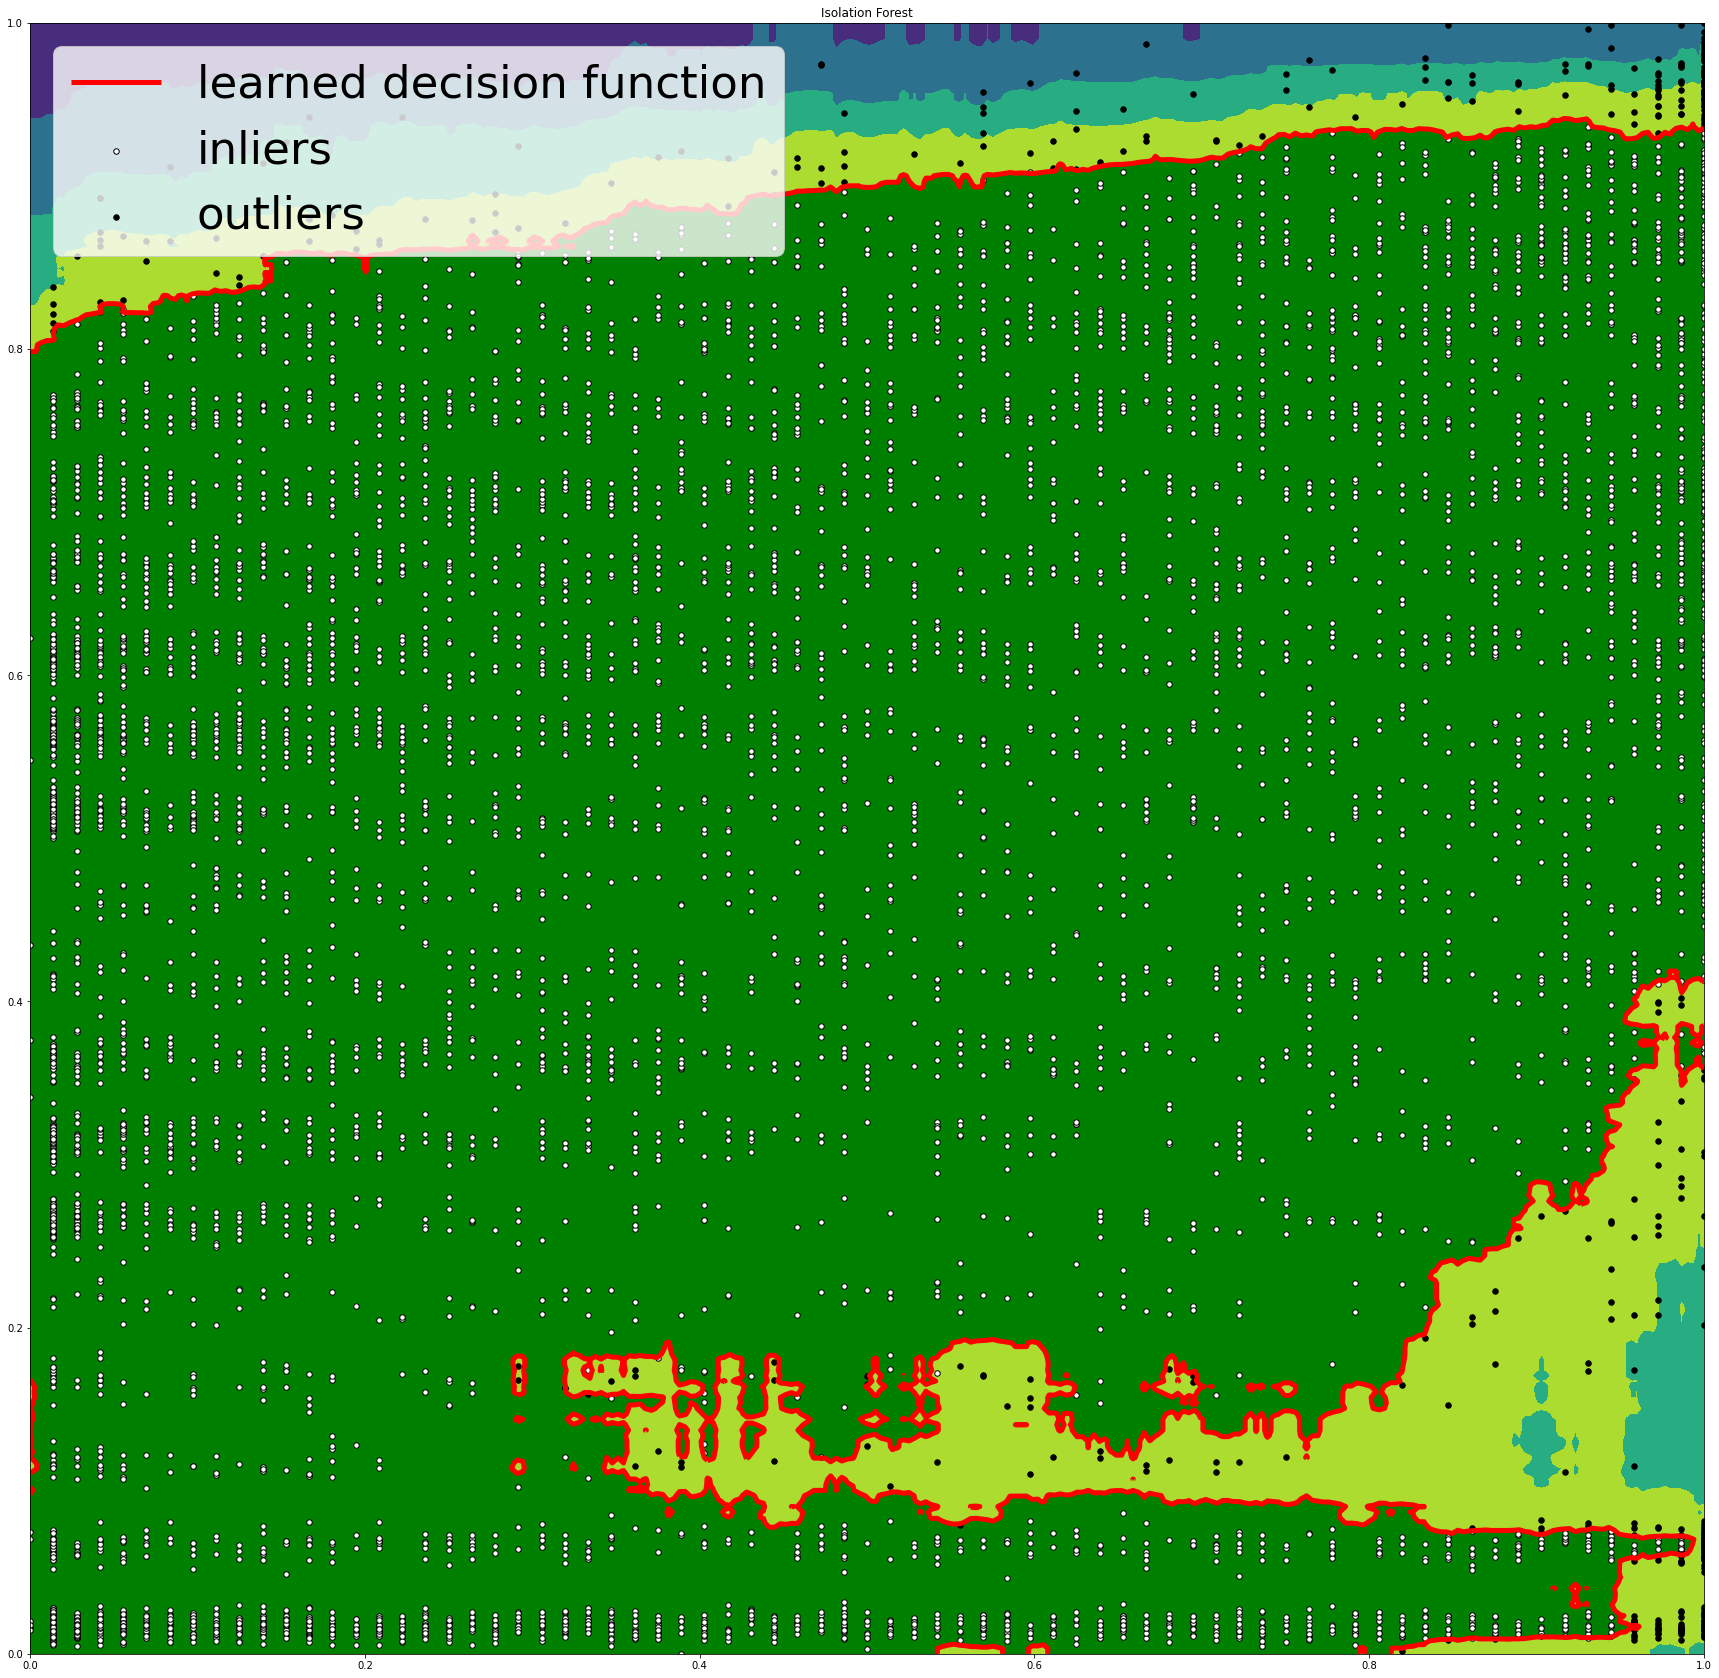

C:\Users\rudra\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\rudra\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\rudra\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\rudra\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\rudra\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\rudra\AppData\Roaming\Python\Py

outliers in this model: 0 normal points: 7043 Angle-based Outlier Detector (ABOD)


C:\Users\rudra\AppData\Local\Temp/ipykernel_5032/3964099069.py:20: UserWarning: The following kwargs were not used by contour: 'c'
  plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 5),c='yellow')


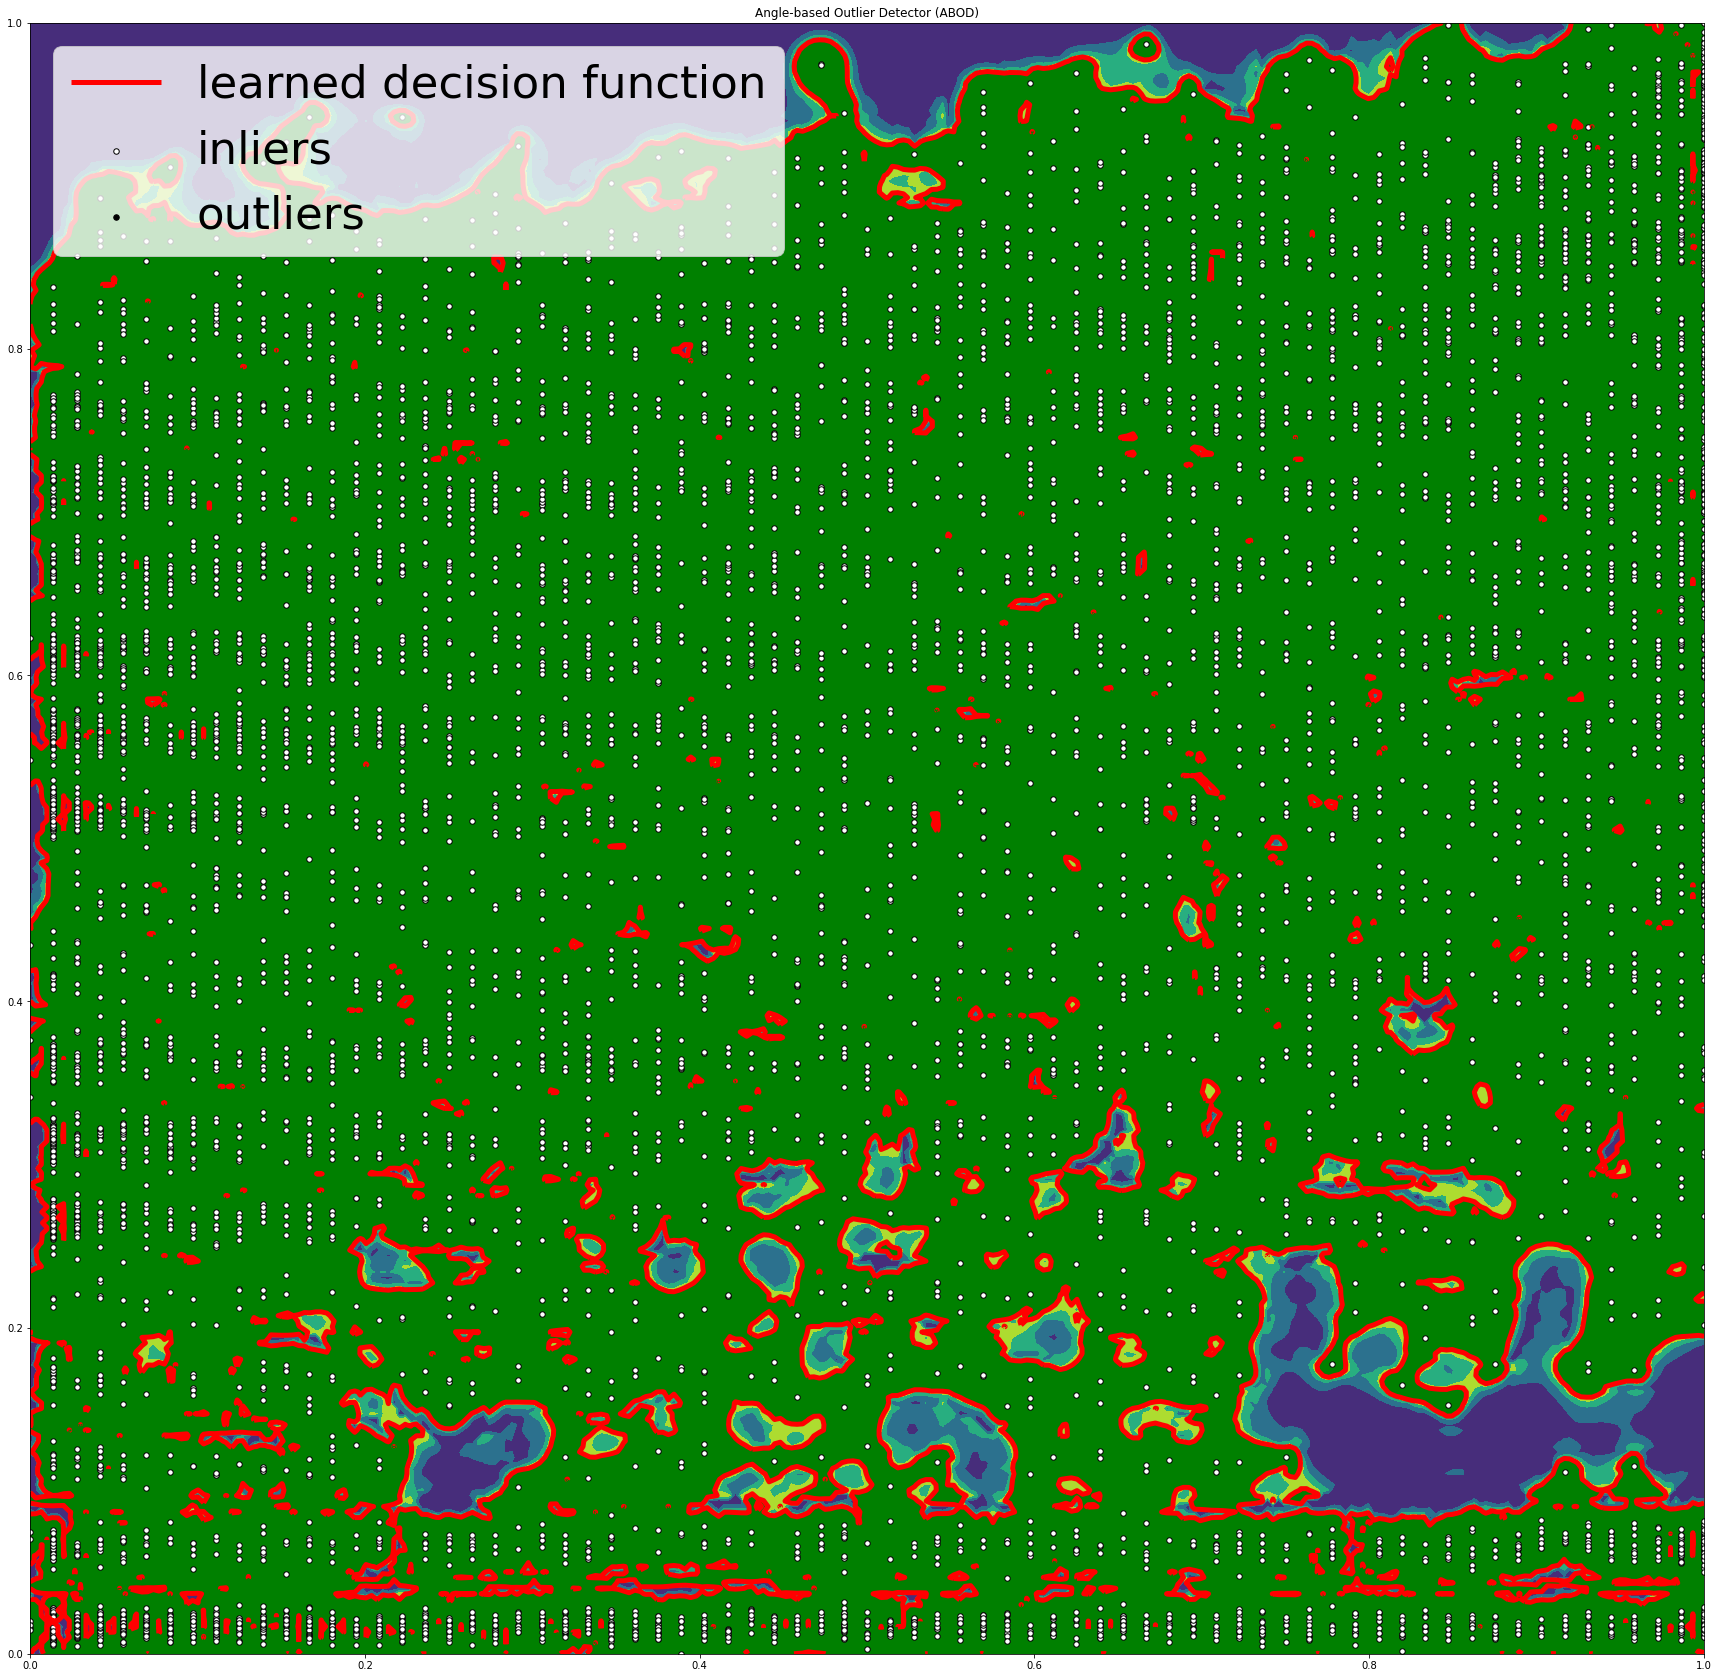

In [16]:
xx , yy = np.meshgrid(np.linspace(0,1 , 300), np.linspace(0, 1, 300))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    scores_pred = clf.decision_function(X) * -1  
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(30, 30))
    dfx = dfo
    dfx['outlier'] = y_pred.tolist()
    IX1 =  np.array(dfx['tenure'][dfx['outlier'] == 0]).reshape(-1,1)
    IX2 =  np.array(dfx['monthlycharges'][dfx['outlier'] == 0]).reshape(-1,1)
    OX1 =  dfx['tenure'][dfx['outlier'] == 1].values.reshape(-1,1)
    OX2 =  dfx['monthlycharges'][dfx['outlier'] == 1].values.reshape(-1,1)       
    print('outliers in this model:',n_outliers,'normal points:',n_inliers, clf_name)
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)    
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 5),c='yellow')
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=5, colors='red')
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='green')
    b = plt.scatter(IX1,IX2, c='white',s=30, edgecolor='k')
    c = plt.scatter(OX1,OX2, c='black',s=30, edgecolor='k')
    plt.axis('tight')  
    plt.legend(
        [a.collections[0], b,c],['learned decision function', 'inliers','outliers'],prop=matplotlib.font_manager.FontProperties(size=45),
        loc=2) 
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()

# Categorizing tenure and monthly charges for chi2 feature selection

In [17]:
def tenure(data):
    if 0 < data  <= 32 :
        a=0
        return a
    else:
        b=1
        return b
df['tenure'] = (df['tenure'].apply(tenure))
def charges(data):
    if 0 < data  <= 70 :
        c=0
        return c
    else:
        d=1
        return d
df['monthlycharges'] = df['monthlycharges'].apply(charges)

# checking unique values in eacch attribute

In [18]:

#df = df.astype({ 'tenure': 'category','monthlycharges': 'category'})
df.nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
tenure              2
phoneservice        2
multiplelines       2
internetservice     3
onlinesecurity      2
onlinebackup        2
deviceprotection    2
techsupport         2
streamingtv         2
streamingmovies     2
contract            3
paperlessbilling    2
paymentmethod       2
monthlycharges      2
churn               2
dtype: int64

In [19]:
#df.to_excel("output.xlsx")

In [20]:
X1 = df.drop(['churn'], axis=1) # input features
y1 = df['churn'] # target variable
#X1 = X1.astype("category")

In [21]:
# prepare input features
oe = OrdinalEncoder()
oe.fit(X1)
X_enc = oe.transform(X1)
# prepare target variable
le = LabelEncoder()
le.fit(y1)
y_enc = le.transform(y1)# plot the scores of features

In [22]:
# feature selection
sf = SelectKBest(chi2, k=10)
sf_fit1 = sf.fit(X1, y1)
# print feature scores
for i in range(len(sf_fit1.scores_)):
    print(' %s: %f' % (X1.columns[i], sf_fit1.scores_[i]))

 gender: 0.254297
 seniorcitizen: 133.482766
 partner: 81.857769
 dependents: 131.271509
 tenure: 331.204748
 phoneservice: 0.092948
 multiplelines: 6.514651
 internetservice: 9.715269
 onlinesecurity: 147.165601
 onlinebackup: 31.209832
 deviceprotection: 20.216007
 techsupport: 135.439602
 streamingtv: 17.320615
 streamingmovies: 15.930611
 contract: 1111.759054
 paperlessbilling: 104.979224
 paymentmethod: 175.733987
 monthlycharges: 142.193735


# Reshaping the df by chosing only the top 10 contributing features + churn column

In [23]:
x_new=sf.fit_transform(X_enc, y_enc)
#np.set_printoptions(threshold=sys.maxsize)
#x_new.shape
cols = sf.get_support(indices=True)
dff = X1.iloc[:,cols]
#churn = df1["churn"]
dff['churn'] = df1['churn'].values
dff
#dff = df1.concat(churn)
#churn

C:\Users\rudra\AppData\Local\Temp/ipykernel_5032/978688099.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['churn'] = df1['churn'].values


,seniorcitizen,partner,dependents,tenure,onlinesecurity,techsupport,contract,paperlessbilling,paymentmethod,monthlycharges,churn
0,0,1,0,0,0,0,0,1,0,0,0
1,0,0,0,1,1,0,1,0,0,0,0
2,0,0,0,0,1,0,0,1,0,0,1
3,0,0,0,1,1,1,1,0,1,0,0
4,0,0,0,0,0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
7038,0,1,1,0,1,1,1,1,0,1,0
7039,0,1,1,1,0,0,1,1,1,1,0
7040,0,1,1,0,1,0,0,1,0,0,0
7041,1,1,0,0,0,0,0,1,0,1,1


# plotting the attributes based on their chi2 scores

C:\Users\rudra\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


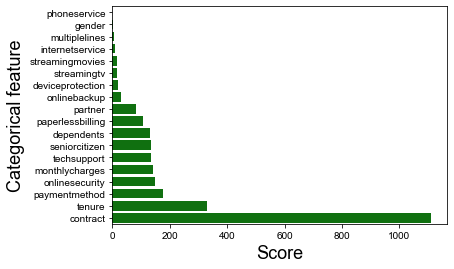

In [24]:
datset1 = pd.DataFrame()
datset1['feature'] = X1.columns[ range(len(sf_fit1.scores_))]
datset1['scores'] = sf_fit1.scores_
datset1 = datset1.sort_values(by='scores', ascending=True)
sns.barplot(datset1['scores'], datset1['feature'], color='green')
sns.set_style('whitegrid')
plt.ylabel('Categorical feature', fontsize=18)
plt.xlabel('Score', fontsize=18)
plt.show()

# Association Rule

In [25]:
df_1=df2[df2['churn']==1]
df_0=df2[df2['churn']==0]
df_1

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,churn
2,1,0,0,0,2,1,0,0,1,1,0,0,0,0,0,1,0,53.85,1
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,0,70.70,1
5,0,0,0,0,8,1,1,1,0,0,1,0,1,1,0,1,0,99.65,1
8,0,0,1,0,28,1,1,1,0,0,1,1,1,1,0,1,0,104.80,1
13,1,0,0,0,49,1,1,1,0,1,1,0,1,1,0,1,1,103.70,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7021,1,0,0,0,12,1,0,0,0,0,0,1,1,0,1,1,0,59.80,1
7026,0,0,0,0,9,1,0,0,0,0,0,0,0,0,0,1,1,44.20,1
7032,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,1,0,75.75,1
7034,0,0,0,0,67,1,1,1,1,1,1,0,1,0,0,1,1,102.95,1


In [26]:
def hot_encode(x): 
    if(x<= 0): 
        return 0
    if(x>= 1): 
        return 1
  
# Encoding the datasets 
df_encoded = df.applymap(hot_encode) 


df_0_encoded= df_0.applymap(hot_encode) 

df_1_encoded = df_1.applymap(hot_encode) 
# Building the model when Churn=1
frq_items = apriori(df_1_encoded, min_support = 0.9, use_colnames = True) 

# Collecting the inferred rules in a dataframe 
rules = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
freq_items=frq_items.sort_values(['support'], ascending=False)
freq_items

,support,itemsets
0,1.000000,(tenure)
2,1.000000,(monthlycharges)
3,1.000000,(churn)
5,1.000000,"(monthlycharges, tenure)"
6,1.000000,"(tenure, churn)"
9,1.000000,"(monthlycharges, churn)"
12,1.000000,"(monthlycharges, churn, tenure)"
1,0.909042,(phoneservice)
4,0.909042,"(phoneservice, tenure)"
7,0.909042,"(phoneservice, monthlycharges)"


In [27]:
frq_items = apriori(df_0_encoded, min_support = 0.90, use_colnames = True) 

# Collecting the inferred rules in a dataframe 
rules = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
freq_items=frq_items.sort_values(['support'], ascending=False)
freq_items

,support,itemsets
0,1.00000,(tenure)
2,1.00000,(monthlycharges)
4,1.00000,"(monthlycharges, tenure)"
1,0.90122,(phoneservice)
3,0.90122,"(phoneservice, tenure)"
5,0.90122,"(phoneservice, monthlycharges)"
6,0.90122,"(phoneservice, monthlycharges, tenure)"


# k++ ELBOW METHOD

In [28]:
# Elbow curve to find optimal K
cost = []
K = range(1,10)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(df)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 49704.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 49704.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 49704.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 49704.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 49704.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1546, cost: 38340.0
Run 1, iteration: 2/100, moves: 217, cost: 38340.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1126, cost: 38244.0
Run 2, iteration: 

Starting iterations...
Run 1, iteration: 1/100, moves: 2613, cost: 28099.0
Run 1, iteration: 2/100, moves: 337, cost: 28099.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1879, cost: 27281.0
Run 2, iteration: 2/100, moves: 98, cost: 27281.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 1997, cost: 28925.0
Run 3, iteration: 2/100, moves: 741, cost: 28748.0
Run 3, iteration: 3/100, moves: 14, cost: 28748.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 2796, cost: 27456.0
Run 4, iteration: 2/100, moves: 874, cost: 27189.0
Run 4, iteration: 3/100, moves: 192, cost: 27189.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 2405, cost: 27569.0
Run 5, iteration: 2/100, moves: 1280, cost: 26905.0
Run 5, iteration: 3/100, moves: 461, cost

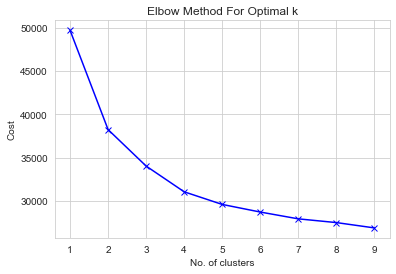

In [29]:
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

# silhouette method to see number of k

In [30]:
from sklearn.metrics import silhouette_score
K = range(2,10)
score_list=[]
for n_clusters in range(2,10):
        clusterer = KModes (n_clusters=n_clusters).fit(df)
        preds = clusterer.predict(df)
        centers = clusterer.cluster_centroids_
        score = silhouette_score (df, preds, metric='euclidean')
        score_list.append(score)
        print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))


For n_clusters = 2, silhouette score is 0.15393652474912434)
For n_clusters = 3, silhouette score is 0.13919418718591922)
For n_clusters = 4, silhouette score is 0.13219882522469917)
For n_clusters = 5, silhouette score is 0.09753912402917762)
For n_clusters = 6, silhouette score is 0.08081128935552943)
For n_clusters = 7, silhouette score is 0.08121526655911628)
For n_clusters = 8, silhouette score is 0.09248224313438029)
For n_clusters = 9, silhouette score is 0.091896225895231)


In [31]:
#len(score_list)

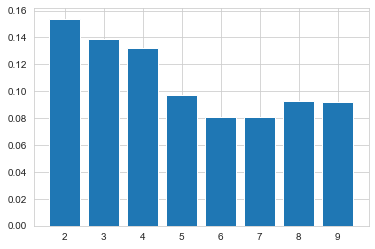

In [32]:
plt.bar(K,score_list)
plt.show()

# KMODE

In [33]:
kmodes = KModes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kmodes.fit_predict(dff)


array([1, 2, 1, ..., 2, 1, 0], dtype=uint16)

In [34]:
# Cluster centorid
kmodes.cluster_centroids_
# Check the iteration of the clusters created
kmodes.n_iter_
# Check the cost of the clusters created
kmodes.cost_
labels = kmodes.labels_
kmodes.cluster_centroids_

array([[0, 1, 0, 1, 1, 1, 2, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0]], dtype=int64)

In [35]:
# Add the cluster to the dataframe
dff['Cluster Labels'] = kmodes.labels_
dff2=dff.copy()

C:\Users\rudra\AppData\Local\Temp/ipykernel_5032/2847548448.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['Cluster Labels'] = kmodes.labels_


In [36]:
# Add the cluster to the dataframe
dff2['Segment'] = dff2['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third'})
dff2['Segment'] = dff2['Segment'].astype('category')
dff2

,seniorcitizen,partner,dependents,tenure,onlinesecurity,techsupport,contract,paperlessbilling,paymentmethod,monthlycharges,churn,Cluster Labels,Segment
0,0,1,0,0,0,0,0,1,0,0,0,1,Second
1,0,0,0,1,1,0,1,0,0,0,0,2,Third
2,0,0,0,0,1,0,0,1,0,0,1,1,Second
3,0,0,0,1,1,1,1,0,1,0,0,0,First
4,0,0,0,0,0,0,0,1,0,1,1,1,Second
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,1,1,0,1,1,1,1,0,1,0,2,Third
7039,0,1,1,1,0,0,1,1,1,1,0,2,Third
7040,0,1,1,0,1,0,0,1,0,0,0,2,Third
7041,1,1,0,0,0,0,0,1,0,1,1,1,Second


In [37]:
list_col = ['Cluster Labels', 'Segment']
cols = [col for col in dff2 if col not in list_col]
# Create an index for cluster interpretation
index = ['First Cluster', 'Second Cluster', 'Third Cluster']
# Create the data frame
pd.DataFrame(kmodes.cluster_centroids_, columns = cols, index = index)

,seniorcitizen,partner,dependents,tenure,onlinesecurity,techsupport,contract,paperlessbilling,paymentmethod,monthlycharges,churn
First Cluster,0,1,0,1,1,1,2,0,1,1,0
Second Cluster,0,0,0,0,0,0,0,1,0,1,0
Third Cluster,0,1,1,1,0,0,1,1,0,0,0


In [38]:
#dfl.drop(labels=['gender','phoneservice','phoneservice','multiplelines','internetservice','onlinebackup','deviceprotection','streamingtv','streamingmovies'], axis=1,inplace=True)
dfl['Cluster Labels'] = kmodes.labels_

# MCA

In [39]:
for col in ['seniorcitizen',
 'partner',
 'dependents',
 'tenure',
 'onlinesecurity',
 'techsupport',
 'contract',
 'paperlessbilling',
 'paymentmethod',
 'monthlycharges',
 'churn','Cluster Labels']:
    dff[col] = dff[col].astype('category')
from prince import MCA
mca = MCA(n_components = 2, n_iter = 3, random_state = 101)
mca.fit(dff)
dff_mca = mca.transform(dff)
dff_mca.head()

C:\Users\rudra\AppData\Local\Temp/ipykernel_5032/1797942769.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff[col] = dff[col].astype('category')


,0,1
0,-0.425880,-0.218552
1,0.267768,-0.438697
2,-0.608838,0.139386
3,0.688313,0.293884
4,-0.770407,0.215646


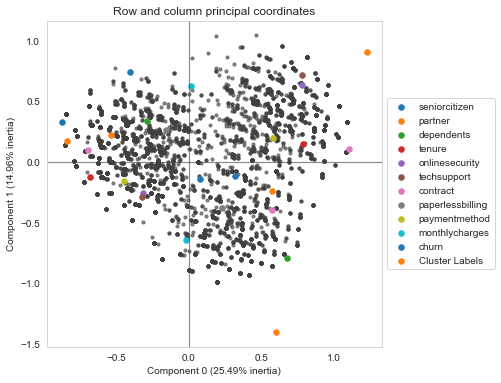

In [40]:
mca.plot_coordinates(X = dff,legend_n_cols=1).legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [41]:
d = dfl[dfl['Cluster Labels'] == 1]
d

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,churn,Cluster Labels
0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,29.85,0,1
2,1,0,0,0,2,1,0,0,1,1,0,0,0,0,0,1,0,53.85,1,1
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,0,70.70,1,1
5,0,0,0,0,8,1,1,1,0,0,1,0,1,1,0,1,0,99.65,1,1
6,1,0,0,1,22,1,1,1,0,1,0,0,1,0,0,1,1,89.10,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7034,0,0,0,0,67,1,1,1,1,1,1,0,1,0,0,1,1,102.95,1,1
7035,1,0,0,0,19,1,0,1,0,0,0,0,1,0,0,1,1,78.70,0,1
7036,0,0,0,0,12,0,0,0,0,1,1,1,1,1,1,0,0,60.65,0,1
7037,0,0,0,0,72,1,0,2,0,0,0,0,0,0,2,1,1,21.15,0,1


# plot result of k-modes method

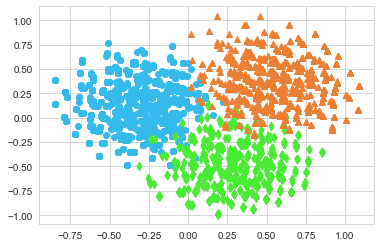

In [42]:
colors = ['#eb8034', '#34baeb', '#49eb34']
markers = ['^', 'o', 'd']
dfl['mca0']=dff_mca[0]
dfl['mca1']=dff_mca[1]
dfl
for c in dfl['Cluster Labels'].unique():
    d = dfl[dfl['Cluster Labels'] == c]
    plt.scatter(d['mca0'], d['mca1'], marker=markers[c], color=colors[c])    
#plt.show()